In [1]:
import os
import torch
import bitsandbytes as bnb
# from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from transformers import BertTokenizer, BertModel

In [2]:
tokenizer_config = {
    'pretrained_model_name_or_path' : r'C:\experiments\bert_tokenizer',
}

***2 Cents on BERT Tokenizer***
- Bert has the following special tokens:
1. `[SEP]`: Placed at the end of each sentence or sequence. Usefull in Next Sequence Prediction Tasks
2. `[CLS]`: Placed at the beginning of the text. Lets the model know about the beginning of the sentence/sequence.

**BERT DOES NOT HAVE `BOS` OR `EOS` TOKENS** 

In [3]:
import random
from torch.utils.data import Dataset, DataLoader

random.seed(42)

class ReviewDataset(Dataset):
    def __init__(self, dir_path, split, tokenizer_config, val=False):
        super().__init__()
        self.review_tags = ['pos', 'neg']
        self.pos_review_dir = os.path.join(dir_path, split, 'pos')
        self.neg_review_dir = os.path.join(dir_path, split, 'neg')
        
        if split == 'train':
            if not val:
                self.pos_label = [self.review_tags[0] for i in os.listdir(self.pos_review_dir)][:200]
                self.neg_label = [self.review_tags[1] for i in os.listdir(self.neg_review_dir)][:200]

                self.reviews = [i for i in os.listdir(self.pos_review_dir)][:200] + [i for i in os.listdir(self.neg_review_dir)][:200]
            else:
                self.pos_label = [self.review_tags[0] for i in os.listdir(self.pos_review_dir)][200:250]
                self.neg_label = [self.review_tags[1] for i in os.listdir(self.neg_review_dir)][200:250]

                self.reviews = [i for i in os.listdir(self.pos_review_dir)][200:250] + [i for i in os.listdir(self.neg_review_dir)][200:250]
        else:
            self.pos_label = [self.review_tags[0] for i in os.listdir(self.pos_review_dir)][:50]
            self.neg_label = [self.review_tags[1] for i in os.listdir(self.neg_review_dir)][:50]

            self.reviews = [i for i in os.listdir(self.pos_review_dir)][:50] + [i for i in os.listdir(self.neg_review_dir)][:50] 
            
        self.label = self.pos_label + self.neg_label
        self.data = [{self.reviews[i] : self.label[i]} for i in range(0, len(self.label))]
        self.tokenizer = BertTokenizer.from_pretrained(**tokenizer_config)
        self.sep_token = self.tokenizer.sep_token
        random.shuffle(self.data)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        sample = self.data[index]
        filename, label = list(sample.items())[0]
        if label == 'pos':
            file_path = os.path.join(self.pos_review_dir, filename)
        else:
            file_path = os.path.join(self.neg_review_dir, filename)
        
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()


        sentences = text.split('.')
        sentences = [i.strip().lower() for i in sentences]
        sentences = [i.replace('<br />', '') for i in sentences]
        sentences = [f'{i} {self.sep_token}' for i in sentences if len(i) != 0]
        text = "".join(sentences) + self.sep_token

        tokens = self.tokenizer(text,
                                max_length=128,
                                truncation=True,
                                padding='max_length',
                                return_tensors='pt').to(device='cuda')
        if label == 'pos':
            return tokens, torch.tensor([1, 0], dtype=torch.float32)
        else:
            return tokens, torch.tensor([0, 1], dtype=torch.float32)

In [4]:
class BertClassifier(torch.nn.Module):
    def __init__(self, num_classes, model_config):
        super().__init__()
        self.num_classes = num_classes
        self.model = BertModel.from_pretrained(**model_config)
        self.classifier = torch.nn.Linear(in_features=768, out_features=num_classes, bias=True)
        self.dropout = torch.nn.Dropout(p=0.7, inplace=True)
        self.softmax = torch.nn.Softmax(dim=1)
    
    def forward(self, x):
        op1 = self.model(**x)
        op2 = self.classifier(op1.pooler_output)
        op3 = self.dropout(op2)
        op4 = self.softmax(op3)
        return op4

In [5]:
model_config = {'pretrained_model_name_or_path' : r'C:\experiments\bert_base_uncased'}
model = BertClassifier(num_classes=2, model_config=model_config).to(device='cuda')

In [6]:
train_dataset = ReviewDataset(
                    dir_path=r'C:\experiments\notebooks\data\reviews\aclImdb',
                    split='train',
                    tokenizer_config=tokenizer_config
)

val_dataset = ReviewDataset(
                    dir_path=r'C:\experiments\notebooks\data\reviews\aclImdb',
                    split='train',
                    tokenizer_config=tokenizer_config,
                    val=True
)


test_dataset = ReviewDataset(
                    dir_path=r'C:\experiments\notebooks\data\reviews\aclImdb',
                    split='test',
                    tokenizer_config=tokenizer_config
)

print(f'Number of reviews in training : {train_dataset.__len__()}')
print(f'Number of reviews in validaton: {val_dataset.__len__()}')
print(f'Number of reviews in test : {test_dataset.__len__()}')


Number of reviews in training : 400
Number of reviews in validaton: 100
Number of reviews in test : 100


In [7]:
train_loader = DataLoader(
                    dataset=train_dataset,
                    batch_size=16,
                    shuffle=True)

val_loader = DataLoader(
                    dataset=val_dataset,
                    batch_size=16,
                    shuffle=True)

test_loader = DataLoader(
                    dataset=test_dataset,
                    batch_size=16,
                    shuffle=True)

In [8]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-5)
criterion = torch.nn.BCEWithLogitsLoss()

In [9]:
EPOCHS = 10

In [10]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

TRAIN_LOSS, VAL_LOSS = list(), list()
TRAIN_ACC, VAL_ACC = list(), list()
for i in range(0, EPOCHS):
        train_loss, train_acc = 0, 0
        model.train()
        for tokens, label in tqdm(train_loader):
                inputs = {
                                'input_ids': tokens['input_ids'].squeeze(1),
                                'token_type_ids' : tokens['token_type_ids'].squeeze(1),
                                'attention_mask' : tokens['attention_mask'].squeeze(1)
                        }
                target = label.to(device='cuda')

                optimizer.zero_grad()
                op = model(inputs)
                loss = criterion(op, target)
                acc = accuracy_score(
                                torch.argmax(op, dim=1).detach().cpu().numpy(), 
                                torch.argmax(target, dim=1).detach().cpu().numpy()
                        )
                train_loss += loss.item()
                train_acc += acc
                loss.backward()
                optimizer.step()
        

        model.eval()
        val_loss, val_acc = 0, 0
        for tokens, label in tqdm(val_loader):
                inputs = {
                                'input_ids': tokens['input_ids'].squeeze(1),
                                'token_type_ids' : tokens['token_type_ids'].squeeze(1),
                                'attention_mask' : tokens['attention_mask'].squeeze(1)
                        }
                target = label.to(device='cuda')

                with torch.no_grad():
                        op = model(inputs)
                        loss = criterion(op, target)
                        acc = accuracy_score(
                                torch.argmax(op, dim=1).detach().cpu().numpy(), 
                                torch.argmax(target, dim=1).detach().cpu().numpy()
                        )
                        
                val_loss += loss.item()
                val_acc += acc


        print(f'EPOCH: {i}\nTrain Loss: {train_loss/len(train_loader)} Train Acc: {train_acc/len(train_loader)}')
        print(f'Val Loss: {val_loss/len(val_loader)} Train Acc: {val_acc/len(val_loader)}')
        
        TRAIN_LOSS.append(train_loss/len(train_loader))
        VAL_LOSS.append(val_loss/len(val_loader))

        TRAIN_ACC.append(train_acc/len(train_loader))
        VAL_ACC.append(val_acc/len(val_loader))
                

100%|██████████| 7/7 [00:01<00:00,  6.32it/s]


EPOCH: 0
Train Loss: 0.7224698233604431 Train Acc: 0.515
Val Loss: 0.7210454089300973 Train Acc: 0.5535714285714286


100%|██████████| 7/7 [00:01<00:00,  6.38it/s]


EPOCH: 1
Train Loss: 0.704135160446167 Train Acc: 0.595
Val Loss: 0.6820815205574036 Train Acc: 0.6607142857142857


100%|██████████| 7/7 [00:01<00:00,  6.35it/s]


EPOCH: 2
Train Loss: 0.6518265056610107 Train Acc: 0.6925
Val Loss: 0.6517179438046047 Train Acc: 0.7321428571428571


100%|██████████| 7/7 [00:01<00:00,  6.25it/s]


EPOCH: 3
Train Loss: 0.6521039271354675 Train Acc: 0.6925
Val Loss: 0.6386903694697789 Train Acc: 0.7410714285714286


100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


EPOCH: 4
Train Loss: 0.6329108858108521 Train Acc: 0.7275
Val Loss: 0.6892247029713222 Train Acc: 0.5982142857142857


100%|██████████| 7/7 [00:01<00:00,  6.24it/s]


EPOCH: 5
Train Loss: 0.6356300973892212 Train Acc: 0.7125
Val Loss: 0.6353660225868225 Train Acc: 0.7589285714285714


100%|██████████| 7/7 [00:01<00:00,  6.32it/s]


EPOCH: 6
Train Loss: 0.621856529712677 Train Acc: 0.7375
Val Loss: 0.6487325344766889 Train Acc: 0.6964285714285714


100%|██████████| 7/7 [00:01<00:00,  6.26it/s]


EPOCH: 7
Train Loss: 0.6272009348869324 Train Acc: 0.7075
Val Loss: 0.6513217432158334 Train Acc: 0.6696428571428571


100%|██████████| 7/7 [00:01<00:00,  6.23it/s]


EPOCH: 8
Train Loss: 0.6201419234275818 Train Acc: 0.7375
Val Loss: 0.6015325954982212 Train Acc: 0.8303571428571429


100%|██████████| 7/7 [00:01<00:00,  6.27it/s]

EPOCH: 9
Train Loss: 0.6147752404212952 Train Acc: 0.7325
Val Loss: 0.5897788660866874 Train Acc: 0.8392857142857143


In [12]:
test_loss, test_acc = 0, 0
for tokens, label in tqdm(test_loader):
    inputs = {
                    'input_ids': tokens['input_ids'].squeeze(1),
                    'token_type_ids' : tokens['token_type_ids'].squeeze(1),
                    'attention_mask' : tokens['attention_mask'].squeeze(1)
            }
    target = label.to(device='cuda')

    with torch.no_grad():
            op = model(inputs)
            loss = criterion(op, target)
            acc = accuracy_score(
                    torch.argmax(op, dim=1).detach().cpu().numpy(), 
                    torch.argmax(target, dim=1).detach().cpu().numpy()
            )
            
    test_loss += loss.item()
    test_acc += acc

print(f'Test Loss: {test_loss/len(test_loader)} Test Acc: {test_acc/len(test_loader)}')

100%|██████████| 7/7 [00:01<00:00,  5.97it/s]

Test Loss: 0.5800503151757377 Test Acc: 0.8392857142857143


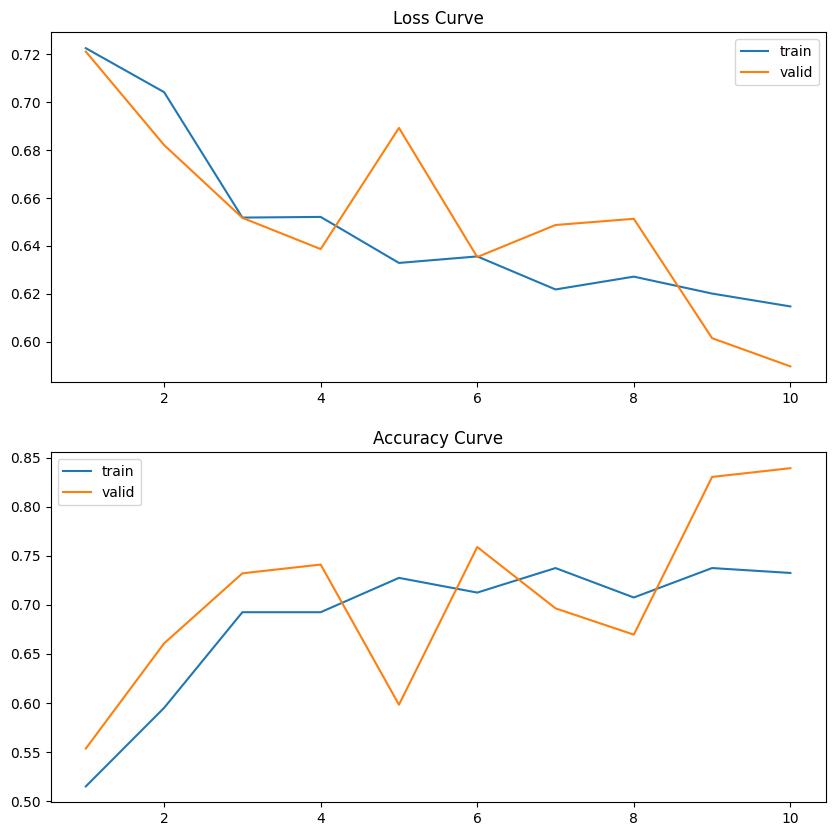

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(10, 10))
ax[0].plot([i+1 for i in range(0, EPOCHS)], TRAIN_LOSS, label = 'train')
ax[0].plot([i+1 for i in range(0, EPOCHS)], VAL_LOSS, label='valid')
ax[0].set_title('Loss Curve')
ax[0].legend()


ax[1].plot([i+1 for i in range(0, EPOCHS)], TRAIN_ACC, label = 'train')
ax[1].plot([i+1 for i in range(0, EPOCHS)], VAL_ACC, label='valid')
ax[1].set_title('Accuracy Curve')
ax[1].legend()
